# Extending `electricmayhem`

In this example notebook we'll write a new pipeline stage. Let's write one that inputs an image and randomly rotates it 0, 90, 180, or 270 degrees.


## Writing a custom pipeline stage


Every pipeline stage should subclass `electricmayhem._pipeline.PipelineBase`, which in turn subclasses `torch.nn.Module`. 

### Required steps

* There should be an `__init__()` method that starts by calling `super().__init__()`. This sets up all the pytorch infrastructure__()`. 
* Any keyword arguments you need to re-initialize agee step should be captured in a JSON/YAML-serializable dict in `self.params`.
* There should be a `forward()` or `_forward_single()` method that does a few things:
  * If called with `control=True`, runs a control batch (same configuration as previous batch but without the patch)
  * If called with `evaluate=True`, runs an evaluation batch (for example possibly using holdout images or a separate model)
  * If a dictionary of paramaters is passed to the `params` kwarg, overrules any randomly-sampled parameters with these values.
  * Can input `**kwargs`
  * Returns a 2-tuple containing that stages' output and the input `kwargs` dictionary (possible with more information added to it)
  * If using `_forward_single()` to apply a transformation to multiple patches, there should be an additional `key` kwarg that can input the patch name (example below).
* There should be a `get_last_sample_as_dict()` method. It should return any stochastic parameters sampled for the last batch as a dictionary containing lists or 1D `numpy` arrays of length `batchsize`

### Optional steps

* Overwrite the `get_description()` method to generate a more useful markdown description for MLFlow.
* Overwrite the `log_vizualizations()` method with any diagnostics that would be useful to log to TensorBoard. This method will get called whenever `pipeline.evaluate()` is run.
* Overwrite the `validate()` method to check for anything specific that could go wrong with that step. When the user calls `Pipeline.validate()` it will run the `validate()` method for each step. Use the `logging` library to record check results at the `info` or `warning` level.

### Other things to know

* If you add an attribute to the object that includes tensors or modules, whether it gets copied to the gpu when you call `.cuda()` depends on how you add it. If you want a tensor to get copied automatically, use `torch.nn.Parameter` or (for a container of them) `torch.nn.ParameterDict`. Modules can be added directly or (for a container of them) `torch.nn.ModuleDict`.

### Toy example

```
class MyPipelineStage(PipelineBase):
    def __init__(self, foo, bar):
        super().__init__()
        self.params = {"foo":foo, "bar":bar}
        
    def forward(self, x, control=False, evaluate=False, params={}, **kwargs):
        <stuff here>
        y = f(x)
        return y, kwargs
        
    def get_last_sample_as_dict(self):
        return dict(<some stuff>)
        
    def log_vizualizations(self, x, x_control, writer, step, logging_to_mlflow=False):
        """
        """
        writer.add_image("name_for_the_tensorboard_log", <some stuff>, global_step=step,
                        logging_to_mlflow=logging_to_mlflow)
         
    def get_description(self):
        return "**MyPipelineStage** and some details that would be helpful in mlflow"
```

In [1]:
import numpy as np
import torch
import sys
sys.path.append("/Users/joe/Documents/electricmayhem/")
import electricmayhem.whitebox as em

/Users/joe/opt/anaconda3/envs/em/lib/python3.9/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
[WARNING 11-30 16:29:05] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [2]:
class RightAngleRotater(em._pipeline.PipelineBase):
    """
    Pipeline stage that rotates images randomly by 0, 90, 180, or 270 degrees
    """
    def __init__(self):
        super().__init__()
        # no parameters for this stage
        self.params = {}
        self.lastsample = []

    def sample(self, N):
        return np.random.randint(0,4, size=N)
    
    def forward(self, x, control=False, evaluate=False, params={}, **kwargs):
        N = x.shape[0]

        # If user passes angles explicitly, override sampling
        if "angle" in params:
            angles = params["angles"]
        # if it's a control batch, use the angles we used last time
        elif control:
            angles = self.lastsample
        # otherwise, sample a random angle for each element in the batch
        else:
            angles = self.sample(N)
        # store this sample in case the next batch is a control batch
        self.lastsample = angles

        # rotate each batch image separately and stack back into a batch
        y = torch.stack([
            torch.rot90(x[i], k=angles[i], dims=[1,2]) for i in range(N)
        ], 0)
        
        return y, kwargs
        
    def get_last_sample_as_dict(self):
        return {"angle":[int(x) for x in self.lastsample]}
        
    def log_vizualizations(self, x, x_control, writer, step, logging_to_mlflow=False):
        """
        Not sure we really need a vizualization for this but we'll add one just to say we did
        """
        rotated = self(x)
        writer.add_image("rotated_image", rotated[0], global_step=step,
                        logging_to_mlflow=logging_to_mlflow)
         

In [3]:
rotater = RightAngleRotater()

In [4]:
img = em.load_to_tensor("data/flower2.png")[:,:240,:240]

In [5]:
img_batch = torch.stack([img for _ in range(10)], 0)
img_batch.shape

torch.Size([10, 3, 240, 240])

In [6]:
rotated, kwargs = rotater(img_batch)
rotated.shape

torch.Size([10, 3, 240, 240])

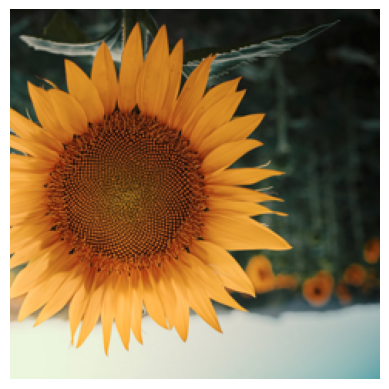

In [7]:
em.plot(rotated[2])

In [8]:
import json
print(json.dumps(rotater.get_last_sample_as_dict()))

{"angle": [0, 0, 2, 2, 0, 2, 2, 0, 3, 2]}


## Adding validation checks

An obvious limitation of this pipeline stage is that it won't work with non-square images, since it won't be able to rotate them 90 or 270 degrees and stack them on top of images rotated 0 or 180 degrees. Whenever there are easy-to-check failure cases, or mistakes you find yourself making a lot while prototyping, I'd encourage you to implement a check by writing a `validate()` method for the class.

`validate()` should:

* input a batch
* return `True` if the batch passes your tests and `False` otherwise
* use `logging` to let the user know what went wrong.

Once a user has assembled stages into a pipeline, they can call `pipeline.validate()` and it will sequentially check each stage.

In [9]:
import logging

class RightAngleRotaterWithValidation(RightAngleRotater):
    def validate(self, x):
        N, C, H, W = x.shape
        if H != W:
            logging.warning(f"{self.__class__.__name__}: image batch isn't square; can't rotate 90 degrees and stack into a batch")
            return False
        return True

Let's reload our test image without clipping it to be square:

In [10]:
img = em.load_to_tensor("data/flower2.png")
img.shape

torch.Size([3, 240, 320])

Now make a simple `Pipeline` object using our `RightAngleRotaterWithValidation` and use the test image to validate it:

In [11]:
pipeline = em.PatchScroller() + RightAngleRotaterWithValidation() + em.PatchResizer((128,128))
pipeline.validate(img)

False

Rearranging stages in the pipeline can fix the problem:

In [12]:
pipeline2 = em.PatchScroller() + em.PatchResizer((128,128)) + RightAngleRotaterWithValidation() 
pipeline2.validate(img)

True

## Writing a `create` stage

Now let's make it a bit more complicated- if we want this pipeline stage to be used as a "create" step that modifies patches before implanting them, then we'll need to handle the case where multiple patches are being trained at once- so the first input to `forward` could be a batch of patches, or a dictionary of batches.

If we don't overwrite the `forward` function, the one in `PipelineBase` will manage both cases and run one or several patches through a `_forward_single()` method. `_forward_single()` will work just like `forward()` did before, but accept an additional `key` argument that tells it which patch it's looking at. This way, when sampled values are exported they can be referenced to the corresponding patch.

The `PipelineBase.forward()` method will also look for a `"keys"` entry in the `params` dictionary and use it to decide which patches to apply to, so you can configure `create` stages to only apply to some of the patches.

The `log_visualizations()` and `validate()` methods will be a bit more complicated to handle the two cases.

In [13]:
class RightAngleRotaterV2(em._pipeline.PipelineBase):
    """
    Pipeline stage that rotates images randomly by 0, 90, 180, or 270 degrees
    """
    def __init__(self, keys=None):
        """
        :keys: None or list of strings; which patches to apply rotation to. If None apply to all patches.
        """
        super().__init__()
        self.params = {}
        if keys is not None:
            self.params["keys"] = keys
        self.lastsample = {}

    def sample(self, N):
        return np.random.randint(0,4, size=N)
        
    def _rotate(self, x, angles):
        N = x.shape[0]
        rotated = torch.stack([
            torch.rot90(x[i], k=angles[i], dims=[1,2]) for i in range(N)
        ], 0)
        return rotated

    def _forward_single(self, x, control=False, evaluate=False, params={}, key=None, **kwargs):
        N = x.shape[0]
        if key is None:
            paramname = "angle"
        else:
            paramname = f"angle_{key}"
        if control:
            angles = self.lastsample[paramname]
        else:
            angles = params.get(paramname, self.sample(N))
            self.lastsample[paramname] = angles
        rotated = self._rotate(x, angles)
        return rotated, kwargs
        
    def get_last_sample_as_dict(self):
        return {k:self.lastsample[k].tolist() for k in self.lastsample}
        
    def log_vizualizations(self, x, x_control, writer, step, logging_to_mlflow=False, suffix=None):
        """
        Not sure we really need a vizualization for this but we'll add one just to say we did
        """
        # SINGLE PATCH CASE
        if isinstance(x, torch.Tensor):
            rotated = self(x)
            if isinstance(suffix, str):
                log_name = f"rotated_image_{suffix}"
            else:
                log_name = "rotated_image"
            writer.add_image(log_name, rotated[0], global_step=step,
                        logging_to_mlflow=logging_to_mlflow)
        # MULTI PATCH CASE
        else:
            for k in x:
                self.log_vizualizations(x[k], x_control[k], writer, step, logging_to_mlflow, suffix=k)

    def validate(self, x, key=""):
        if isinstance(x, torch.Tensor):
            N, C, H, W = x.shape
            if H != W:
                logging.warning(f"{self.__class__.__name__}: {key} image batch isn't square; can't rotate 90 degrees and stack into a batch")
                return False
            return True
        else:
            if "keys" in self.params:
                keys = self.params["keys"]
            else:
                keys = list(x.keys())
            all_pass = True
            for k in keys:
                patch_val = self.validate(x[k], key=k)
                if not patch_val:
                    all_pass = False
            return all_pass



Let's test a multipatch case with one square and one rectangular patch:

In [14]:
patches = {
    "square":em.load_to_tensor("data/flower2.png")[:,:240,:240],
    "rect":em.load_to_tensor("data/flower2.png")
}

Predictably we'll get a nastygram when we try validating this:

In [15]:
pipeline = em.PatchScroller() + RightAngleRotaterV2() + em.PatchResizer((128,128))
pipeline.validate(patches)

False

Since we added an option to choose which patches the rotater applies to, we could define the same pipeline and tell it to skip over the rectangular one:

In [16]:
pipeline = em.PatchScroller() + RightAngleRotaterV2(keys=["square"]) + em.PatchResizer((128,128))
pipeline.validate(patches)

True

In [17]:
patch_batch = {k:patches[k].unsqueeze(0) for k in patches}
output, _ = pipeline(patch_batch)

In [18]:
[output[k].shape for k in output]

[torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 128, 128])]

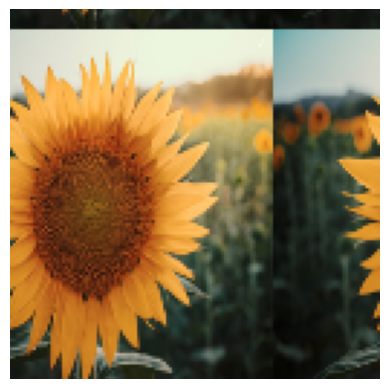

In [19]:
em.plot(output["rect"].squeeze(0))

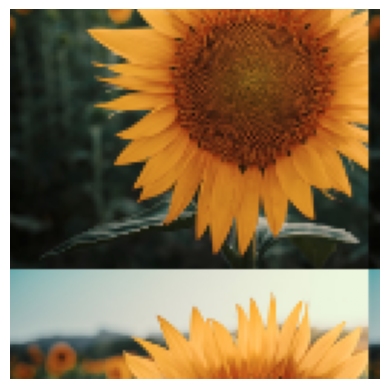

In [20]:
em.plot(output["square"].squeeze(0))